# Problem 7: Layer Normalization & Residuals - Interactive Notebook

Explore layer normalization and residual connections.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# When finished, uncomment the following sentence and import your own solution
from solution import ResidualConnection
# from problem import ResidualConnection

torch.manual_seed(42)
plt.rcParams['figure.figsize'] = (12, 8)
print('Setup complete!')

Setup complete!


## Visualize Layer Normalization Effect

/tmp/ipykernel_79994/2312383307.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot([x[0, i, :].detach().numpy() for i in range(5)], labels=[f'Pos {i}' for i in range(5)])
/tmp/ipykernel_79994/2312383307.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot([x_normalized[0, i, :].detach().numpy() for i in range(5)], labels=[f'Pos {i}' for i in range(5)])


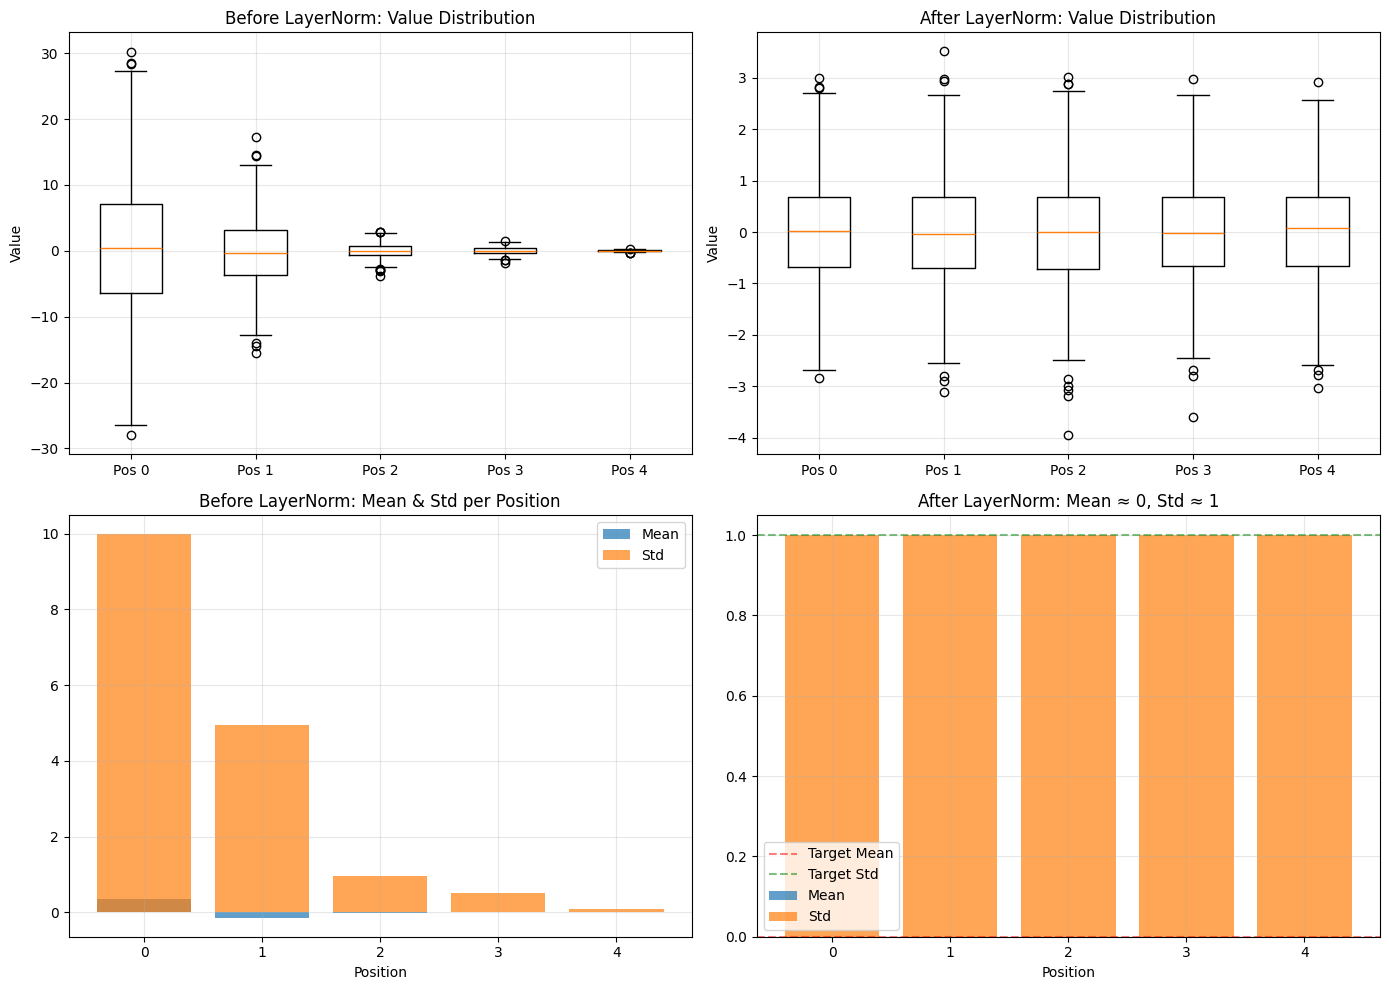

Layer Normalization ensures mean ≈ 0 and std ≈ 1 for each position!


In [2]:
# Create input with varying scales
n_embd = 768
x = torch.randn(1, 5, n_embd)

# Scale different positions differently
x[0, 0, :] *= 10   # Large values
x[0, 1, :] *= 5
x[0, 2, :] *= 1
x[0, 3, :] *= 0.5
x[0, 4, :] *= 0.1  # Small values

# Apply layer normalization
ln = nn.LayerNorm(n_embd)
x_normalized = ln(x)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Before normalization - values
axes[0, 0].boxplot([x[0, i, :].detach().numpy() for i in range(5)], labels=[f'Pos {i}' for i in range(5)])
axes[0, 0].set_title('Before LayerNorm: Value Distribution')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(alpha=0.3)

# After normalization - values
axes[0, 1].boxplot([x_normalized[0, i, :].detach().numpy() for i in range(5)], labels=[f'Pos {i}' for i in range(5)])
axes[0, 1].set_title('After LayerNorm: Value Distribution')
axes[0, 1].set_ylabel('Value')
axes[0, 1].grid(alpha=0.3)

# Mean and std before
means_before = x.mean(dim=-1).squeeze().detach().numpy()
stds_before = x.std(dim=-1).squeeze().detach().numpy()
axes[1, 0].bar(range(5), means_before, alpha=0.7, label='Mean')
axes[1, 0].bar(range(5), stds_before, alpha=0.7, label='Std')
axes[1, 0].set_title('Before LayerNorm: Mean & Std per Position')
axes[1, 0].set_xlabel('Position')
axes[1, 0].set_xticks(range(5))
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Mean and std after
means_after = x_normalized.mean(dim=-1).squeeze().detach().numpy()
stds_after = x_normalized.std(dim=-1, unbiased=False).squeeze().detach().numpy()
axes[1, 1].bar(range(5), means_after, alpha=0.7, label='Mean')
axes[1, 1].bar(range(5), stds_after, alpha=0.7, label='Std')
axes[1, 1].set_title('After LayerNorm: Mean ≈ 0, Std ≈ 1')
axes[1, 1].set_xlabel('Position')
axes[1, 1].set_xticks(range(5))
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Target Mean')
axes[1, 1].axhline(y=1, color='g', linestyle='--', alpha=0.5, label='Target Std')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('Layer Normalization ensures mean ≈ 0 and std ≈ 1 for each position!')

## Compare With and Without Residual Connection

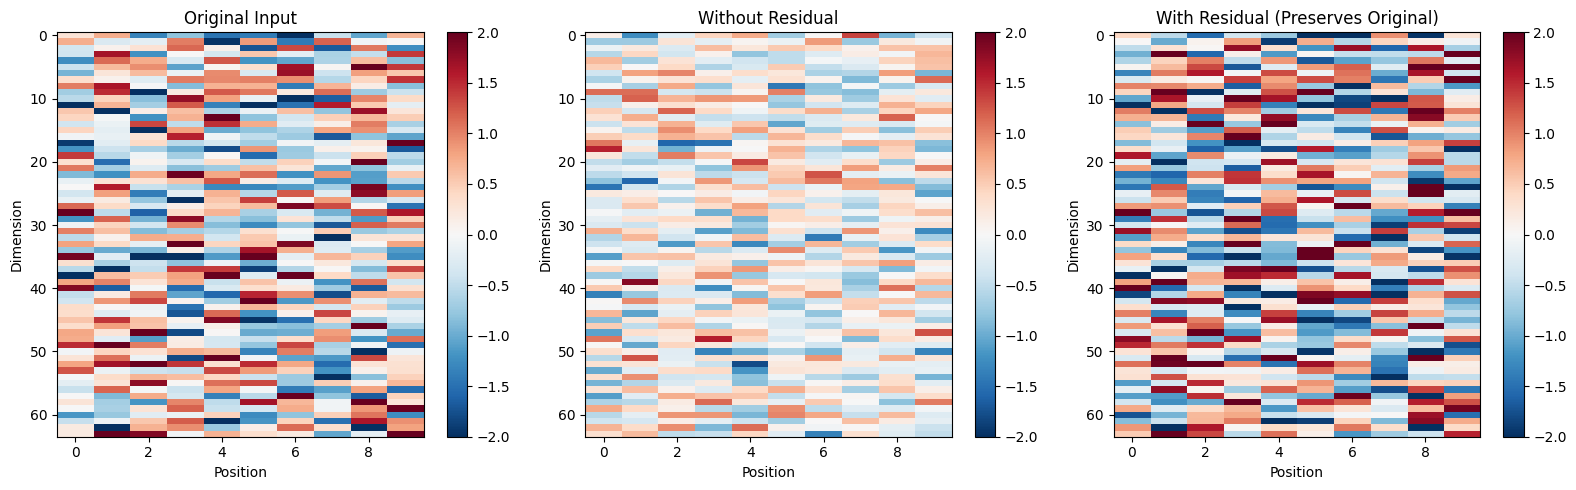

Residual connection preserves information from the input!


In [3]:
# Create a simple sublayer (linear transformation)
n_embd = 64
linear = nn.Linear(n_embd, n_embd)
sublayer = lambda x: linear(x)

x = torch.randn(1, 10, n_embd)

# Without residual (just sublayer)
ln = nn.LayerNorm(n_embd)
output_no_residual = sublayer(ln(x))

# With residual
res = ResidualConnection(n_embd=n_embd, dropout=0.0)
res.eval()
output_with_residual = res(x, sublayer)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Original input
im1 = axes[0].imshow(x.squeeze().detach().T.numpy(), aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
axes[0].set_title('Original Input')
axes[0].set_xlabel('Position')
axes[0].set_ylabel('Dimension')
plt.colorbar(im1, ax=axes[0])

# Without residual
im2 = axes[1].imshow(output_no_residual.squeeze().detach().T.numpy(), aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
axes[1].set_title('Without Residual')
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Dimension')
plt.colorbar(im2, ax=axes[1])

# With residual
im3 = axes[2].imshow(output_with_residual.squeeze().detach().T.numpy(), aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
axes[2].set_title('With Residual (Preserves Original)')
axes[2].set_xlabel('Position')
axes[2].set_ylabel('Dimension')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print('Residual connection preserves information from the input!')

## Demonstrate Gradient Flow

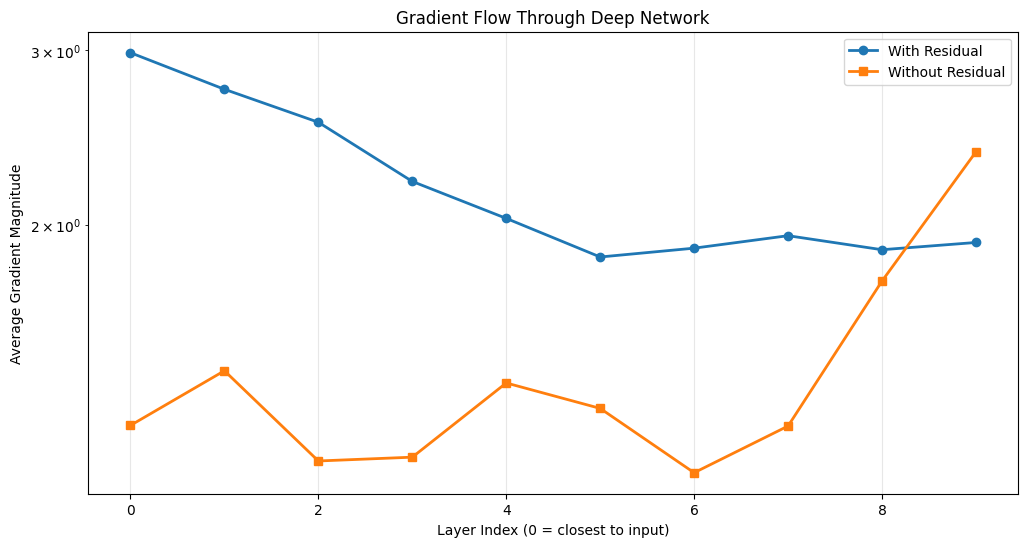

Residual connections help gradients flow more uniformly!
Without residual, gradients can vanish in early layers.


In [4]:
# Compare gradient flow with and without residual
def measure_gradient_flow(use_residual=True, n_layers=10):
    """Measure how gradients flow through multiple layers."""
    n_embd = 64
    x = torch.randn(1, 5, n_embd, requires_grad=True)
    
    output = x
    layers = []
    
    for i in range(n_layers):
        linear = nn.Linear(n_embd, n_embd)
        layers.append(linear)
        
        if use_residual:
            res = ResidualConnection(n_embd=n_embd, dropout=0.0)
            output = res(output, lambda x: linear(x))
        else:
            ln = nn.LayerNorm(n_embd)
            output = linear(ln(output))
    
    loss = output.sum()
    loss.backward()
    
    # Measure gradient magnitude at each layer
    grad_magnitudes = [layer.weight.grad.abs().mean().item() for layer in layers]
    
    return grad_magnitudes

# Measure gradients
n_layers = 10
grads_with_residual = measure_gradient_flow(use_residual=True, n_layers=n_layers)
grads_without_residual = measure_gradient_flow(use_residual=False, n_layers=n_layers)

plt.figure(figsize=(12, 6))
plt.plot(range(n_layers), grads_with_residual, 'o-', label='With Residual', linewidth=2)
plt.plot(range(n_layers), grads_without_residual, 's-', label='Without Residual', linewidth=2)
plt.xlabel('Layer Index (0 = closest to input)')
plt.ylabel('Average Gradient Magnitude')
plt.title('Gradient Flow Through Deep Network')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

print('Residual connections help gradients flow more uniformly!')
print(f'Without residual, gradients can vanish in early layers.')

## Test Pre-Norm vs Post-Norm

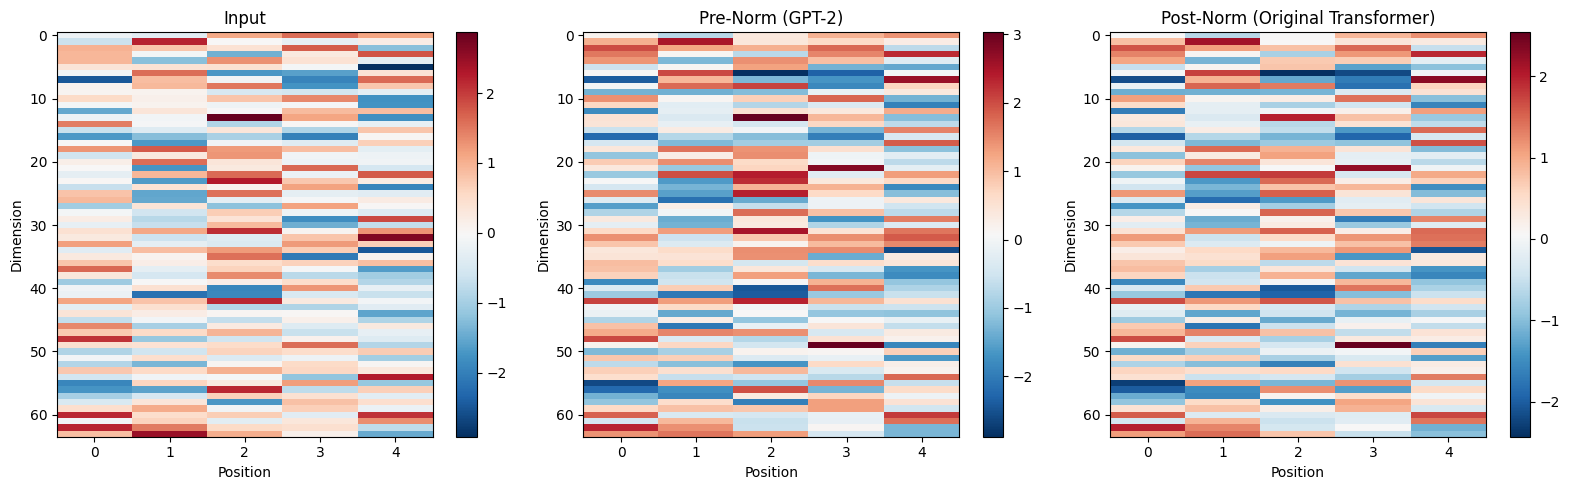

Pre-norm (GPT-2): Normalizes BEFORE sublayer
Post-norm (Original): Normalizes AFTER sublayer

Pre-norm is more stable for deep networks!


In [5]:
# Compare pre-norm (GPT-2) vs post-norm (original Transformer)
n_embd = 64
linear = nn.Linear(n_embd, n_embd)
ln = nn.LayerNorm(n_embd)

x = torch.randn(1, 5, n_embd)

# Pre-norm: x + sublayer(ln(x))
pre_norm_output = x + linear(ln(x))

# Post-norm: ln(x + sublayer(x))
post_norm_output = ln(x + linear(x))

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Input
im1 = axes[0].imshow(x.squeeze().detach().T.numpy(), aspect='auto', cmap='RdBu_r')
axes[0].set_title('Input')
axes[0].set_xlabel('Position')
axes[0].set_ylabel('Dimension')
plt.colorbar(im1, ax=axes[0])

# Pre-norm (GPT-2)
im2 = axes[1].imshow(pre_norm_output.squeeze().detach().T.numpy(), aspect='auto', cmap='RdBu_r')
axes[1].set_title('Pre-Norm (GPT-2)')
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Dimension')
plt.colorbar(im2, ax=axes[1])

# Post-norm (Original Transformer)
im3 = axes[2].imshow(post_norm_output.squeeze().detach().T.numpy(), aspect='auto', cmap='RdBu_r')
axes[2].set_title('Post-Norm (Original Transformer)')
axes[2].set_xlabel('Position')
axes[2].set_ylabel('Dimension')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print('Pre-norm (GPT-2): Normalizes BEFORE sublayer')
print('Post-norm (Original): Normalizes AFTER sublayer')
print('\nPre-norm is more stable for deep networks!')

## Verify Your Implementation

In [6]:
# Quick verification
res = ResidualConnection(n_embd=768, dropout=0.1)
linear = nn.Linear(768, 768)
sublayer = lambda x: linear(x)

x_test = torch.randn(2, 10, 768)
output = res(x_test, sublayer)

print('✓ ResidualConnection implemented')
print('✓ Layer normalization applied')
print(f'✓ Shape preserved: {x_test.shape} → {output.shape}')
print('✓ Residual connection working')
print('\n✅ Basic functionality verified!')
print('\nRun "python -m pytest test_layer_norm.py -v" for complete validation.')

✓ ResidualConnection implemented
✓ Layer normalization applied
✓ Shape preserved: torch.Size([2, 10, 768]) → torch.Size([2, 10, 768])
✓ Residual connection working

✅ Basic functionality verified!

Run "python -m pytest test_layer_norm.py -v" for complete validation.
